# Fundamental Factor Models

By Beha Abasi, Maxwell Margenot, and Delaney Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

## What are Fundamental Factor Models?

Fundamental data refers to the metrics and ratios measuring the financial characteristics of companies derived from the public filings made by these companies, such as their income statements and balance sheets. Examples of factors drawn from these documents include market cap, net income growth, and cash flow.

This fundamental data can be used in many ways, one of which is to build a linear factor model. Given a set of $k$ fundamental factors, we can represent the returns of an asset, $R_t$, as follows:

$$R_t = \alpha_t + \beta_{t, F_1}F_1 + \beta_{t, F_2}F_2 + ... + \beta_{t, F_k}F_k + \epsilon_t$$

where each $F_j$ represents a fundamental factor return stream. These return streams are from portfolios whose value is derived from it's respective factor.

Fundamental factor models try to determine characteristics that affect an asset's risk and return. The most difficult part of this is determining which factors to use. Much research has been done on determining significant factors, and what makes things even more difficult is that the discovery of a significant factor often leads to its advantage being arbitraged away! This is one of the reasons why fundamental factor models, and linear factor models in general, are so prevalent in modern finance. Once you have found significant factors, you need to calculate the exposure an asset's return stream has to each factor. This is similar to the calculation of risk premia discussed in the [CAPM lecture](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory).

In using fundamental data, we run into the problem of having factors that may not be easily compared due to their varying units and magnitudes. To resolve this, we take two different approaches to bring the data onto the same level - portfolio construction to compare return streams and normalization of factor values.

## Approach One: Portfolio Construction

The first approach consists of using the fundamental data as a ranking scheme and creating a [long-short equity portfolio](https://www.quantopian.com/lectures/long-short-equity) based on each factor. We then use the return streams associated with each portfolio as our model factors. 

One of the most well-known examples of this approach is the Fama-French model. The Fama-French model, and later the Carhart four factor model, adds market cap, book-to-price ratios, and momentum to the original CAPM, which only included market risk. 

Historically, certain groups of stocks were seen as outperforming the market, namely those with small market caps, high book-to-price ratios, and those that had previously done well (i.e., they had momentum). Empirically, Fama & French found that the returns of these particular types of stocks tended to be better than what was predicted by the security market line of the CAPM.

In order to capture these phenomena, we will use those factors to create a ranking scheme that will be used in the creation of long short equity portfolios. The factors will be $SMB$, measuring the excess return of small market cap companies minus big, $HML$, measuring the excess return of companies with high book-to-price ratios versus low, $MOM$, measuring the excess returns of last month's winners versus last month's losers, and $EXMRKT$ which is a measure of the market risk.

In general, this approach can be used as an asset pricing model or to hedge our portfolios. The latter uses Fama-Macbeth regressions to calculate risk premia, as demonstrated in the CAPM lecture. Hedging can be achieved through a linear regression of portfolio returns on the returns from the long-short factor portfolios. Below are examples of both.

### Portfolio Construction as an Asset Pricing Model

First we import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import CustomFactor, Returns, Latest
from quantopian.pipeline.classifiers import Classifier
from quantopian.pipeline.filters import Q1500US
from quantopian.research import run_pipeline
import matplotlib.pyplot as plt

Use pipeline to get all of our factor data that we will use in the rest of the lecture.

In [2]:
class Momentum(CustomFactor):
    # will give us the returns from last month
    inputs = [Returns(window_length=20)]
    window_length = 20
    
    def compute(self, today, assets, out, lag_returns):
        out[:] = lag_returns[0]


def make_pipeline():
    # define our fundamental factor pipeline
    pipe = Pipeline()
    
    # market cap and book-to-price data gets fed in here
    market_cap = Latest([Fundamentals.market_cap])
    book_to_price = 1/Latest([Fundamentals.pb_ratio])
    # and momentum as lagged returns (1 month lag)
    momentum = Momentum()
    # we also get daily returns
    returns = Returns(window_length=2)
    
    # we compute a daily rank of both factors, this is used in the next step,
    # which is computing portfolio membership
    market_cap_rank = market_cap.rank(mask=Q1500US())
    book_to_price_rank = book_to_price.rank(mask=Q1500US())
    momentum_rank = momentum.rank(mask=Q1500US())
    
    # Grab the top and bottom 1000 for each factor
    biggest = market_cap_rank.top(1000)
    smallest = market_cap_rank.bottom(1000)
    
    highpb = book_to_price_rank.top(1000)
    lowpb = book_to_price_rank.bottom(1000)
    
    top = momentum_rank.top(1000)
    bottom = momentum_rank.bottom(1000)
    
    # Define our universe, screening out anything that isn't in the top or bottom
    universe = Q1500US() & (biggest | smallest | highpb | lowpb | top | bottom)
    
    pipe = Pipeline(
        columns = {
            'market_cap':market_cap,
            'book_to_price':book_to_price,
            'momentum':momentum,
            'Returns':returns,
            'market_cap_rank':market_cap_rank,
            'book_to_price_rank':book_to_price_rank,
            'momentum_rank':momentum_rank,
            'biggest':biggest,
            'smallest':smallest,
            'highpb':highpb,
            'lowpb':lowpb,
            'top':top,
            'bottom':bottom
        },
        screen=universe
    )
    
    return pipe

# Initializing the pipe
pipe = make_pipeline()

# Dependency Graph
pipe.show_graph('png')

# Now let's start the pipeline
start_date, end_date = '2016-01-01', '2016-12-31' 

results = run_pipeline(pipe, start_date, end_date)

results.head()

Returns biggest  book_to_price  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])  -0.010040    True       0.969455   
                          Equity(24 [AAPL]) -0.019474    True       0.203379   
                          Equity(53 [ABMD]) -0.020408    True       0.086460   
                          Equity(62 [ABT])  -0.007733    True       0.315122   
                          Equity(67 [ADSK]) -0.021365    True       0.126237   

                                             book_to_price_rank bottom highpb  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])               1335.0   True   True   
                          Equity(24 [AAPL])               417.0   True  False   
                          Equity(53 [ABMD])               145.0   True  False   
                          Equity(62 [ABT])                677.0   True   True   
                          Equity(67 [ADSK])               227.0  False  False   

                                             lowpb    market_cap  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])   False  1.293097e+10   
                          Equity(24 [AAPL])   True  5.868593e+11   
                          Equity(53 [ABMD])   True  3.829449e+09   
                          Equity(62 [ABT])    True  6.699314e+10   
                          Equity(67 [ADSK])   True  1.372894e+10   

                                             market_cap_rank  momentum  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])            1164.0 -0.022826   
                          Equity(24 [AAPL])           1500.0 -0.047304   
                          Equity(53 [ABMD])            685.0 -0.031261   
                          Equity(62 [ABT])            1436.0 -0.022355   
                          Equity(67 [ADSK])           1181.0  0.013375   

                                             momentum_rank smallest    top  
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])           701.0    False   True  
                          Equity(24 [AAPL])          476.0    False  False  
                          Equity(53 [ABMD])          625.0     True   True  
                          Equity(62 [ABT])           711.0    False   True  
                          Equity(67 [ADSK])         1110.0    False   True

Now we can go through the data and build the factor portfolios we want

In [3]:
# group_by(level=0).mean() gives you the average return of each day for a particular group of stocks
R_biggest = results[results.biggest]['Returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['Returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['Returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['Returns'].groupby(level=0).mean()

R_top = results[results.top]['Returns'].groupby(level=0).mean()
R_bottom = results[results.bottom]['Returns'].groupby(level=0).mean()

# risk-free proxy
R_F = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# find it's beta against market
M = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]

# Defining our final factors
EXMRKT = M - R_F
SMB = R_smallest - R_biggest # small minus big
HML = R_highpb - R_lowpb # high minus low
MOM = R_top - R_bottom # momentum

Now that we've constructed our portfolios, let's look at our performance if we were to hold each one.

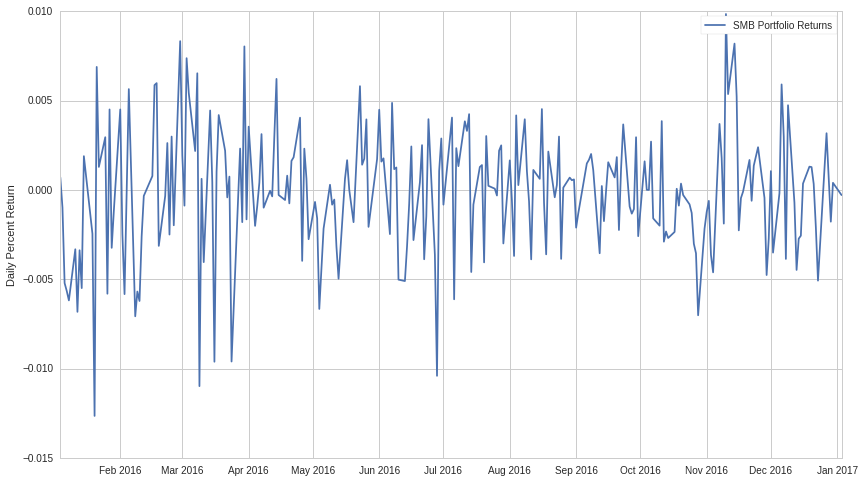

In [4]:
plt.plot(SMB.index, SMB.values)
plt.ylabel('Daily Percent Return')
plt.legend(['SMB Portfolio Returns']);

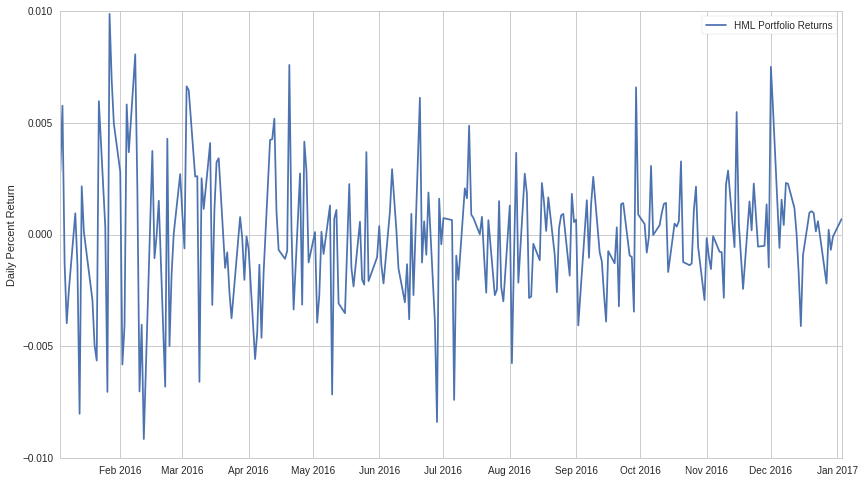

In [5]:
plt.plot(HML.index, HML.values)
plt.ylabel('Daily Percent Return')
plt.legend(['HML Portfolio Returns']);

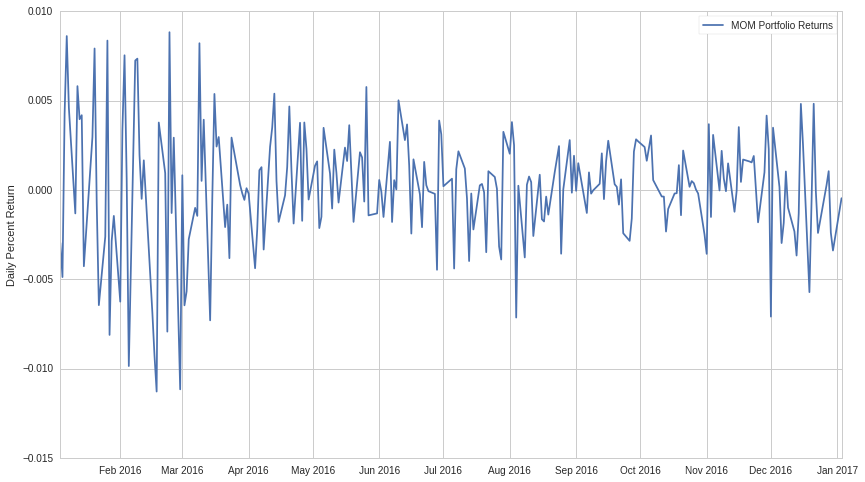

In [6]:
plt.plot(MOM.index, MOM.values)
plt.ylabel('Daily Percent Return')
plt.legend(['MOM Portfolio Returns']);

Now, as we did in the CAPM lecture, we'll calculate the risk premia on each of these factors using the Fama-Macbeth regressions.



In [7]:
import itertools
import statsmodels.api as sm
from statsmodels import regression,stats
import scipy

Our asset returns data is asset and date specific, whereas our factor portfolio returns are only date specific. Therefore, we'll need to spread each day's portfolio return across all the assets for which we have data for on that day.

In [8]:
data = results[['Returns']].set_index(results.index)
asset_list_sizes = [group[1].size for group in data.groupby(level=0)]

# Spreading the factor portfolio data across all assets for each day
SMB_column = [[SMB.loc[group[0]]] * size for group, size \
              in zip(data.groupby(level=0), asset_list_sizes)]
data['SMB'] = list(itertools.chain(*SMB_column))

HML_column = [[HML.loc[group[0]]] * size for group, size \
              in zip(data.groupby(level=0), asset_list_sizes)]
data['HML'] = list(itertools.chain(*HML_column))

MOM_column = [[MOM.loc[group[0]]] * size for group, size \
              in zip(data.groupby(level=0), asset_list_sizes)]
data['MOM'] = list(itertools.chain(*MOM_column))

EXMRKT_column = [[EXMRKT.loc[group[0]]]*size if group[0] in EXMRKT.index else [None]*size \
                 for group, size in zip(data.groupby(level=0), asset_list_sizes)]

data['EXMRKT'] = list(itertools.chain(*EXMRKT_column))

data = sm.add_constant(data.dropna())

# Our list of assets from pipeline
assets = data.index.levels[1].unique()

# gathering our data to be asset-specific
Y = [data.xs(asset, level=1)['Returns'] for asset in assets] 
X = [data.xs(asset, level=1)[['EXMRKT','SMB', 'HML', 'MOM', 'const']] for asset in assets]

# First regression step: estimating the betas
reg_results = [regression.linear_model.OLS(y, x).fit().params \
               for y, x in zip(Y, X) if not(x.empty or y.empty)]
indices = [asset for y, x, asset in zip(Y, X, assets) if not(x.empty or y.empty)]

betas = pd.DataFrame(reg_results, index=indices)
betas = sm.add_constant(betas.drop('const', axis=1))

R = data['Returns'].mean(axis=0, level=1)

# Second regression step: estimating the risk premia
risk_free_rate = np.mean(R_F)

final_results = regression.linear_model.OLS(R - risk_free_rate, betas).fit()

final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     233.0
Date:                Sat, 07 Oct 2017   Prob (F-statistic):          3.00e-159
Time:                        18:21:44   Log-Likelihood:                 7439.7
No. Observations:                1686   AIC:                        -1.487e+04
Df Residuals:                    1681   BIC:                        -1.484e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0007      0.000      6.279      0.000         0.000     0.001
EXMRKT         0.0041      0.000     24.889      0.000         0.004     0.004
SMB            0.0001   3.77e-05      3.371      0.001      5.31e-05     0.000
HML           -0.0003   3.02e-05    -10.200      0.000        -0.000    -0.000
MOM         -2.94e-05   5.11e-05     -0.575      0.565        -0.000  7.09e-05
==============================================================================
Omnibus:                     1708.454   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           144118.051
Skew:                          -4.707   Prob(JB):                         0.00
Kurtosis:                      47.304   Cond. No.                         22.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Returns Prediction
As discussed in the CAPM lecture, factor modeling can be used to predict future returns based on current fundamental factors. As well, it could be used to determine when an asset may be mispriced in order to arbitrage the difference, as shown in the CAPM lecture.

Modeling future returns is accomplished by offsetting the returns in the regression, so that rather than predict for current returns, you are predicting for future returns. Once you have a predictive model, the most canonical way to create a strategy is to attempt a long-short equity approach.

### Portfolio Construction for Hedging

Once we've determined that we are exposed to a factor, we may want to avoid depending on the performance of that factor by taking out a hedge. This is discussed in more detail in the Beta Hedging and Risk Factor Exposure lectures. The essential idea is to take the exposure your return stream has to a factor, and short the proportional value. So, if your total portfolio value was $V$, and the exposure you calculated to a certain factor return stream was $\beta$, you would short $\beta V$ amount of that return stream.

The following is an example using the Fama-French factors we used before.

In [9]:
# we'll take a random sample of 500 assets from Q1500US in order to build a random portfolio
random_assets = list(np.random.choice(assets, size=500, replace=False))

portfolio_data = data[data.index.isin(random_assets, level=1)]

# this is the return of our portfolio with no hedging
R_portfolio_time_series = portfolio_data['Returns'].mean(level=0)

In [10]:
# next, we calculate the exposure of our portfolio to each of the Fama-French factors
portfolio_exposure = regression.linear_model.OLS(portfolio_data['Returns'], \
                                portfolio_data[['EXMRKT', 'SMB', 'HML', 'MOM', 'const']]).fit()

print portfolio_exposure.summary()

# our hedged return stream
hedged_portfolio = R_portfolio_time_series - \
                portfolio_exposure.params[0]*EXMRKT - \
                portfolio_exposure.params[1]*SMB - \
                portfolio_exposure.params[2]*HML - \
                portfolio_exposure.params[3]*MOM 

print 'Mean, Std of Hedged Portfolio:', np.mean(hedged_portfolio), np.std(hedged_portfolio)
print 'Mean, Std of Unhedged Portfolio:', np.mean(R_portfolio_time_series), np.std(R_portfolio_time_series)


                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     3599.
Date:                Sat, 07 Oct 2017   Prob (F-statistic):               0.00
Time:                        18:21:44   Log-Likelihood:             2.5396e+05
No. Observations:              108991   AIC:                        -5.079e+05
Df Residuals:                  108986   BIC:                        -5.079e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
EXMRKT        -0.1094      0.009    -12.475      0.0

Let's look at a graph of our two portfolio return streams

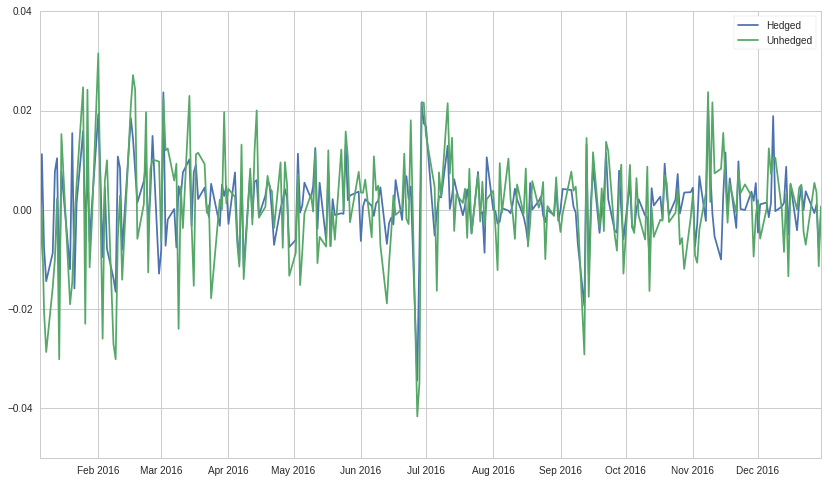

In [11]:
plt.plot(hedged_portfolio)

plt.plot(R_portfolio_time_series)

plt.legend(['Hedged', 'Unhedged']);

We'll check for normality, homoskedasticity, and autocorrelation in this model. For more information on the tests below, check out the [Violations of Regression Models](https://www.quantopian.com/lectures/violations-of-regression-models#notebook) lecture.

For normality, we'll run a Jarque-Bera test, which tests whether our data's skew/kurtosis matches that of a normal distribution. As the standard, we'll reject the null hypothesis that our data is normally distributed if our p-value falls under our confidence level of 5%.

To test for heteroskedasticity, we'll run a Breush-Pagan test, which tests whether the variance of the errors in a linear regression is related to the values of the independent variables. In this case, our null hypothesis is that the data is homoskedastic.

Autocorrelation is tested for using the Durbin-Watson statistic, which looks at the lagged relationship between the errors in a regression. This will give you a number between 0 and 4, with 2 meaning no autocorrelation. 

In [12]:
# testing for normality: jarque-bera
_, pvalue_JB, _, _ = stats.stattools.jarque_bera(portfolio_exposure.resid)
print "Jarque-Bera p-value: ", pvalue_JB

# testing for homoskedasticity: breush pagan
_, pvalue_BP, _, _ = stats.diagnostic.het_breushpagan(portfolio_exposure.resid, \
                                            portfolio_data[['EXMRKT', 'SMB', 'HML', 'MOM', 'const']])
print "Breush Pagan p-value: ", pvalue_BP

# testing for autocorrelation
dw = stats.stattools.durbin_watson(portfolio_exposure.resid)
print "Durbin Watson statistic: ", dw

Jarque-Bera p-value:  0.0
Breush Pagan p-value:  0.0345137159935
Durbin Watson statistic:  1.77334074161


Based on the Jarque-Bera p-value, we would reject the null hypothesis that the data is normally distributed. This means there is strong evidence that our data follows some other distribution.

The test for homoskedasticity suggests that the data is heteroskedastic. However, we need to be careful about this test as we saw that our data may not be normally distributed.

Finally, the Durbin-Watson statistic can be evaluated by looking at the critical values of the statistic. At a confidence level of 95% and 4 explanatory variables, we cannot reject the null hypothesis of no autocorrelation. 

## Approach Two: Factor Value Normalization

Another approach is to normalize factor values for each day and see how predictive of that day's returns they were. This is also known as cross-sectional factor analysis. We do this by computing a normalized factor value $b_{a,j}$ for each asset $a$ in the following way. 

$$b_{a,j} = \frac{F_{a,j} - \mu_{F_j}}{\sigma_{F_j}}$$

$F_{a,j}$ is the value of factor $j$ for asset $a$ during this time, $\mu_{F_j}$ is the mean factor value across all assets, and $\sigma_{F_j}$ is the standard deviation of factor values over all assets. Notice that we are just computing a z-score to make asset specific factor values comparable across different factors.

The exceptions to this formula are indicator variables, which are set to 1 for true and 0 for false. One example is industry membership: the coefficient tells us whether the asset belongs to the industry or not. 

After we calculate all of the normalized scores during time $t$, we can estimate factor $j$'s returns $F_{j,t}$, using a cross-sectional regression (i.e. at each time step, we perform a regression using the equations for all of the assets). Specifically, once we have returns for each asset $R_{a,t}$, and normalized factor coefficients $b_{a,j}$, we construct the following model and estimate the $F_j$s and $a_t$

$$R_{a,t} = a_t + b_{a,F_1}F_1 + b_{a, F_2}F_2 + \dots + b_{a, F_K}F_K$$

You can think of this as slicing through the other direction from the first analysis, as now the factor returns are unknowns to be solved for, whereas originally the coefficients were the unknowns. Another way to think about it is that you're determining how predictive of returns the factor was on that day, and therefore how much return you could have squeezed out of that factor.

Following this procedure, we'll get the cross-sectional returns on 2016-11-22, and compute the coefficients for all assets:

We can take the fundamental data we got from the pipeline call above.

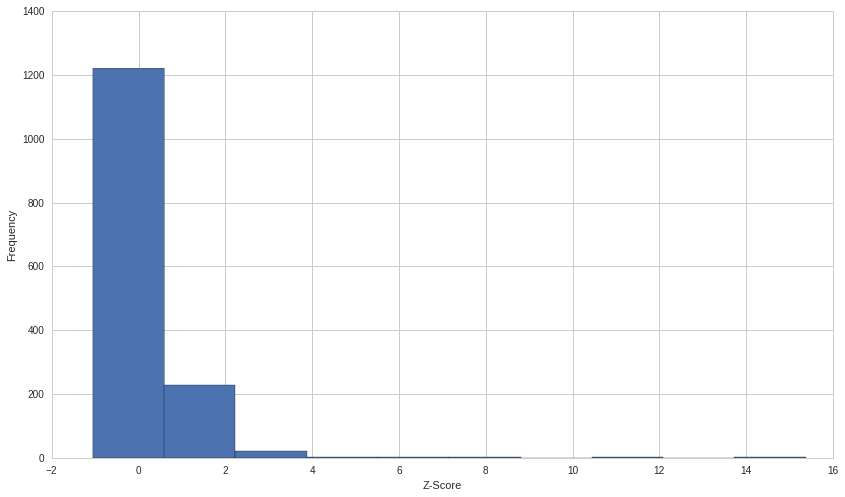

In [13]:
date = '2016-11-22'

BTP = results['book_to_price'][date]
z_score = (BTP - BTP.mean()) / BTP.std()
z_score.dropna(inplace=True)

plt.hist(z_score)
plt.xlabel('Z-Score')
plt.ylabel('Frequency')

#### Problem: The Data is Weirdly Distributed
Notice how there are big outliers in the dataset that cause the z-scores to lose a lot of information. Basically the presence of some very large outliers causes the rest of the data to occupy a relatively small area. We can get around this issue using some data cleaning techniques, such as winsorization.

#### Winsorization
Winzorization takes the top $n\%$ of a dataset and sets it all equal to the least extreme value in the top $n\%$. For example, if your dataset ranged from 0-10, plus a few crazy outliers, those outliers would be set to 0 or 10 depending on their direction. The following is an example.

In [14]:
# Get some random data
random_data = np.random.normal(0, 1, 100)

# Put in some outliers
random_data[0] = 1000
random_data[1] = -1000

# Perform winsorization
print 'Before winsorization', np.min(random_data), np.max(random_data)
scipy.stats.mstats.winsorize(random_data, inplace=True, limits=0.01)
print 'After winsorization', np.min(random_data), np.max(random_data)

Before winsorization -1000.0 1000.0
After winsorization -2.12265371697 1.91999796298


We'll apply the same technique to our data and grab the returns to all the assets in our universe. Then we'll run a linear regression to estimate $F_j$.

In [15]:
BTP = scipy.stats.mstats.winsorize(results['book_to_price'][date], limits=0.01)
BTP_z = (BTP - np.mean(BTP)) / np.std(BTP)

MC = scipy.stats.mstats.winsorize(results['market_cap'][date], limits=0.01)
MC_z = (MC - np.mean(MC)) / np.std(MC)

Lag_Ret = scipy.stats.mstats.winsorize(results['momentum'][date], limits=0.01)
Lag_Ret_z = (Lag_Ret - np.mean(Lag_Ret)) / np.std(Lag_Ret)

returns = results['Returns'][date]

df_day = pd.DataFrame({'R': returns,
              'BTP_z': BTP_z,
              'MC_z': MC_z,
              'Lag_Ret_z': Lag_Ret_z,
              'Constant': 1}).dropna()

cross_sectional_results = \
    regression.linear_model.OLS(df_day['R'], df_day[['BTP_z', 'MC_z', 'Lag_Ret_z', 'Constant']]).fit()

cross_sectional_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.118
Date:                Sat, 07 Oct 2017   Prob (F-statistic):             0.0961
Time:                        18:21:45   Log-Likelihood:                 3932.6
No. Observations:                1489   AIC:                            -7857.
Df Residuals:                    1485   BIC:                            -7836.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
BTP_z       2.039e-06      0.000      0.005      0.996        -0.001     0.001
MC_z          -0.0001      0.000     -0.318      0.751        -0.001     0.001
Lag_Ret_z      0.0011      0.000      2.511      0.012         0.000     0.002
Constant       0.0073      0.000     16.333      0.000         0.006     0.008
==============================================================================
Omnibus:                      519.946   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15556.041
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                      18.708   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To expand this analysis, you would simply loop through days, running this every day and getting an estimated factor return.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*